In [1]:
from pre_processing.get_books import get_preprocessed_data
from pre_processing.frequency_inverse import get_freq_inverse
from pre_processing.get_all_words import get_all_words

from analysis.k_means import k_means_analysis


from analysis.cosine_similarity import get_cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.cluster import SpectralClustering

from analysis.multidimensional_scaling import get_multi_scaling_positions
from analysis.multidimensional_scaling import get_LSA_scaling_positions
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import nltk

from gensim import corpora, models, similarities 

from sklearn.decomposition import NMF


NUMBERS_ONLY = False

IF_MIN = 0.1
IF_MAX = 0.9
N_GRAMS = 3

K_MEANS_N_CLUSTERS = 6

UseMDS=True

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/ayoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
list_of_books = get_preprocessed_data(NUMBERS_ONLY)
frequency_term_matrix, terms, term_freq_vectorizer = get_freq_inverse(list_of_books,IF_MAX,IF_MIN,N_GRAMS)


(24, 169607)


In [3]:
from sklearn.linear_model import LassoLarsIC

In [4]:
book_words_list = []
all_words_list = []
for book in list_of_books:
    book_words_list.append(" ".join(book.word_list))

for book_words in book_words_list:
    words = [word.lower() for sentence in nltk.sent_tokenize(book_words) for word in nltk.word_tokenize(sentence)]
    filtered_tokens = []
    for word in words:
        filtered_tokens.append(word)
    all_words_list.extend(filtered_tokens)


In [5]:
km = KMeans(n_clusters=K_MEANS_N_CLUSTERS)
km.fit(frequency_term_matrix)
clusters = km.labels_.tolist()


titles = []
published = []
authors = []
period = []
for book in list_of_books:
    authors.append(book.meta["author"])
    titles.append(book.meta["title"])
    published.append(book.meta["published"])
    period.append(book.meta["period"])

books = {'titles': titles, 'cluster': clusters, 'published': published, 'authors':authors, 'period':period}
frame = pd.DataFrame(books, index = [clusters] , columns = ['titles', 'cluster', 'published','authors', 'period']).sort_index()
frame.to_csv("kmeansresults.csv")

In [6]:
vocab_frame = pd.DataFrame({'words': all_words_list}, index=all_words_list)
cluster_names = {}
for i in range(K_MEANS_N_CLUSTERS):
    cluster_names[i] = []
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

In [7]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
if not NUMBERS_ONLY:
    for i in range(K_MEANS_N_CLUSTERS):
            for ind in order_centroids[i, :K_MEANS_N_CLUSTERS]:  # replace 6 with n words per cluster
                cluster_names[i].append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
else:
    for i in range(K_MEANS_N_CLUSTERS):
        #print("Cluster {} words:".format(i))
        for ind in order_centroids[i, :K_MEANS_N_CLUSTERS]:  # replace 6 with n words per cluster
            cluster_names[i].append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])

In [23]:
posMDS = get_multi_scaling_positions(frequency_term_matrix, False)

posLSA = get_LSA_scaling_positions(frequency_term_matrix)

if UseMDS:
    pos = posMDS
    
else:
    pos = posLSA
print(pos)

False
[[-0.42688459 -0.32148973]
 [-0.76419938  0.01937146]
 [-0.00827732  0.12799042]
 [ 0.43435652 -0.48216512]
 [ 0.34460887 -0.33075627]
 [-0.22733258  0.40099014]
 [-0.23876969 -0.21069722]
 [ 0.64130332 -0.08285141]
 [ 0.08437368  0.58837313]
 [ 0.20554085  0.51262457]
 [ 0.64585614  0.31030826]
 [-0.17673221 -0.48073864]
 [-0.58050954  0.31228682]
 [-0.09581449 -0.5458712 ]
 [-0.29966121 -0.52056064]
 [ 0.45662766 -0.39803756]
 [ 0.31684517  0.62830905]
 [ 0.59462526  0.2177535 ]
 [-0.28875034  0.65881054]
 [-0.4281703   0.32343102]
 [ 0.35663946 -0.49172265]
 [-0.32300648 -0.46318142]
 [ 0.25089619  0.24296029]
 [-0.47356498 -0.01513733]]


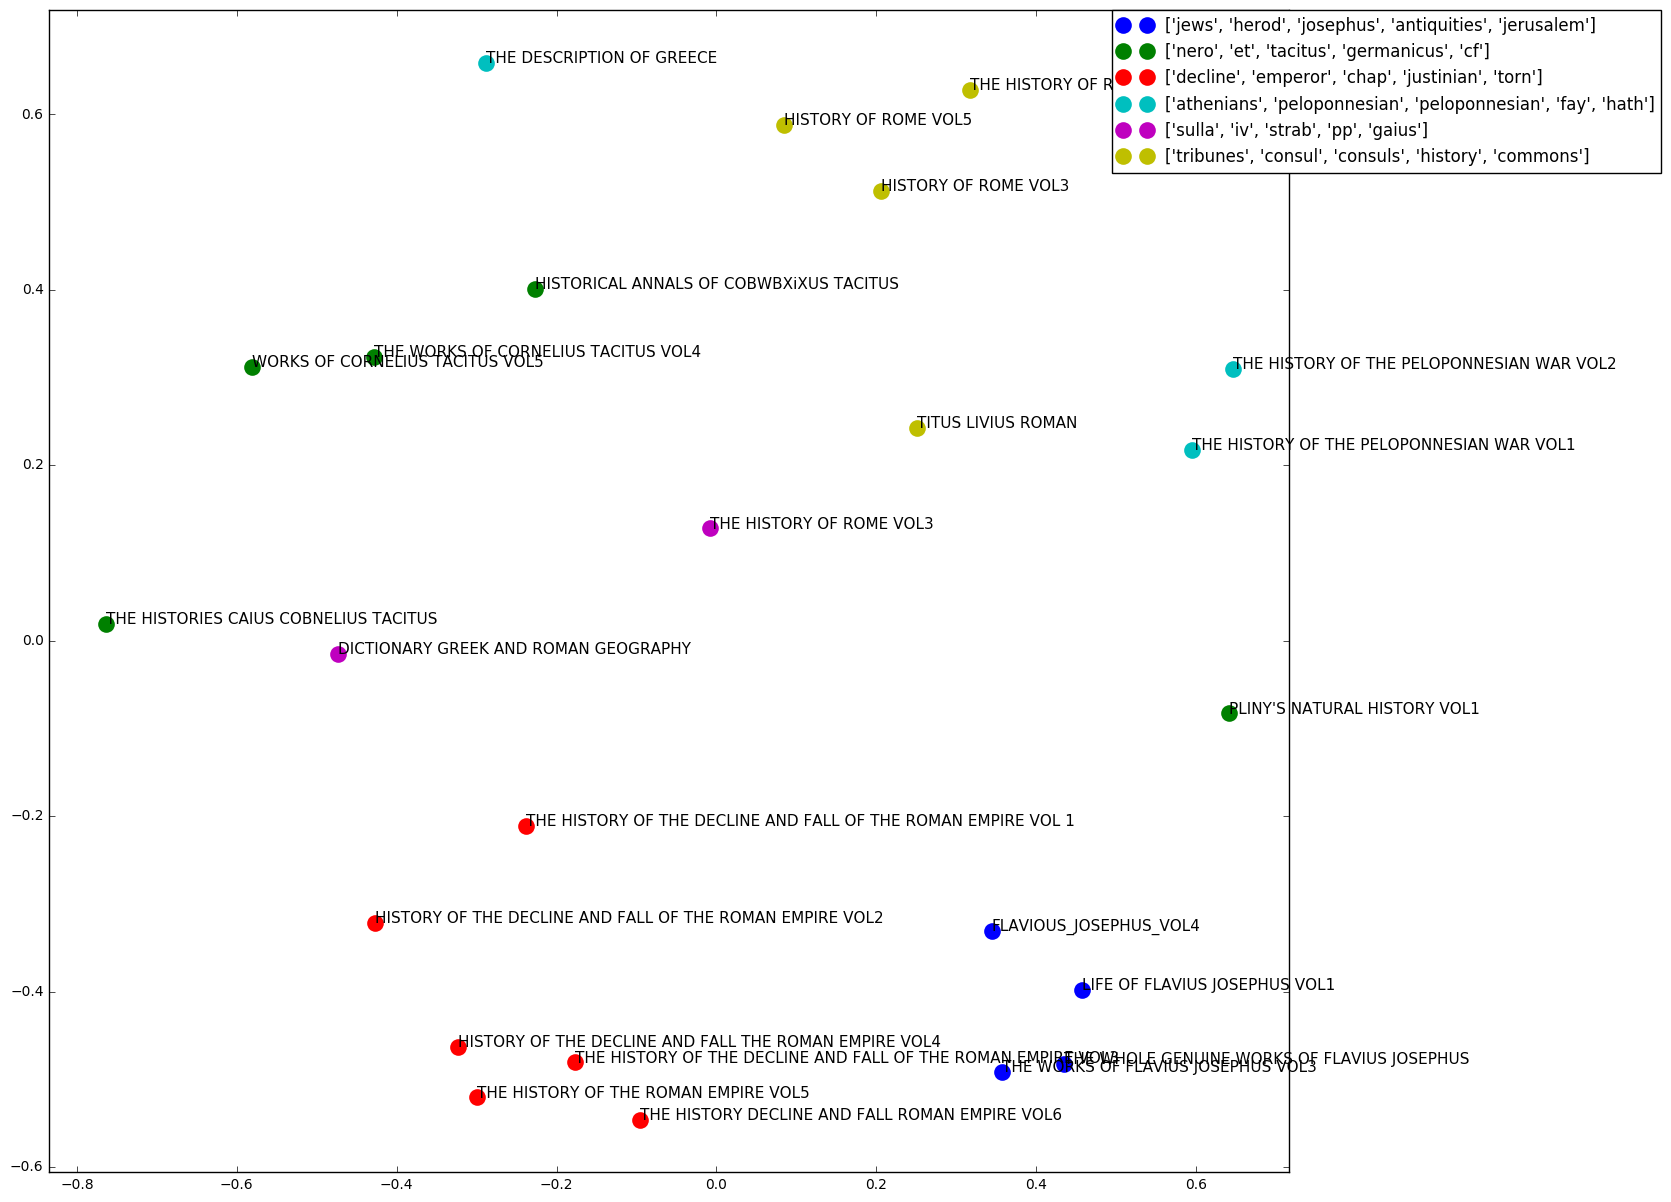

In [9]:

graph_dict = {'x':posMDS[:, 0], 'y':posMDS[:, 1], 'label':clusters, 'title':titles}
df = pd.DataFrame(graph_dict)

groups = df.groupby('label')
#posMDS

ig, ax = plt.subplots(figsize=(16, 15))  # set size
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_names[name][0:5],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params( \
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
    )
    ax.tick_params( \
        axis='y',  # changes apply to the y-axis
        which='both',  # both major and minor ticks are affected
       )

    ax.legend(numpoints=1)  # show legend with only 1 point
    ax.legend(loc='center left', bbox_to_anchor=(0.85,0.93))


# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# add label in x,y position with the label as the book title

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=11)

df.ix[2]
ig.savefig('kmeans6topics.pdf')


label                           4
title    THE HISTORY OF ROME VOL3
x                        0.325111
y                      0.00580297
Name: 2, dtype: object

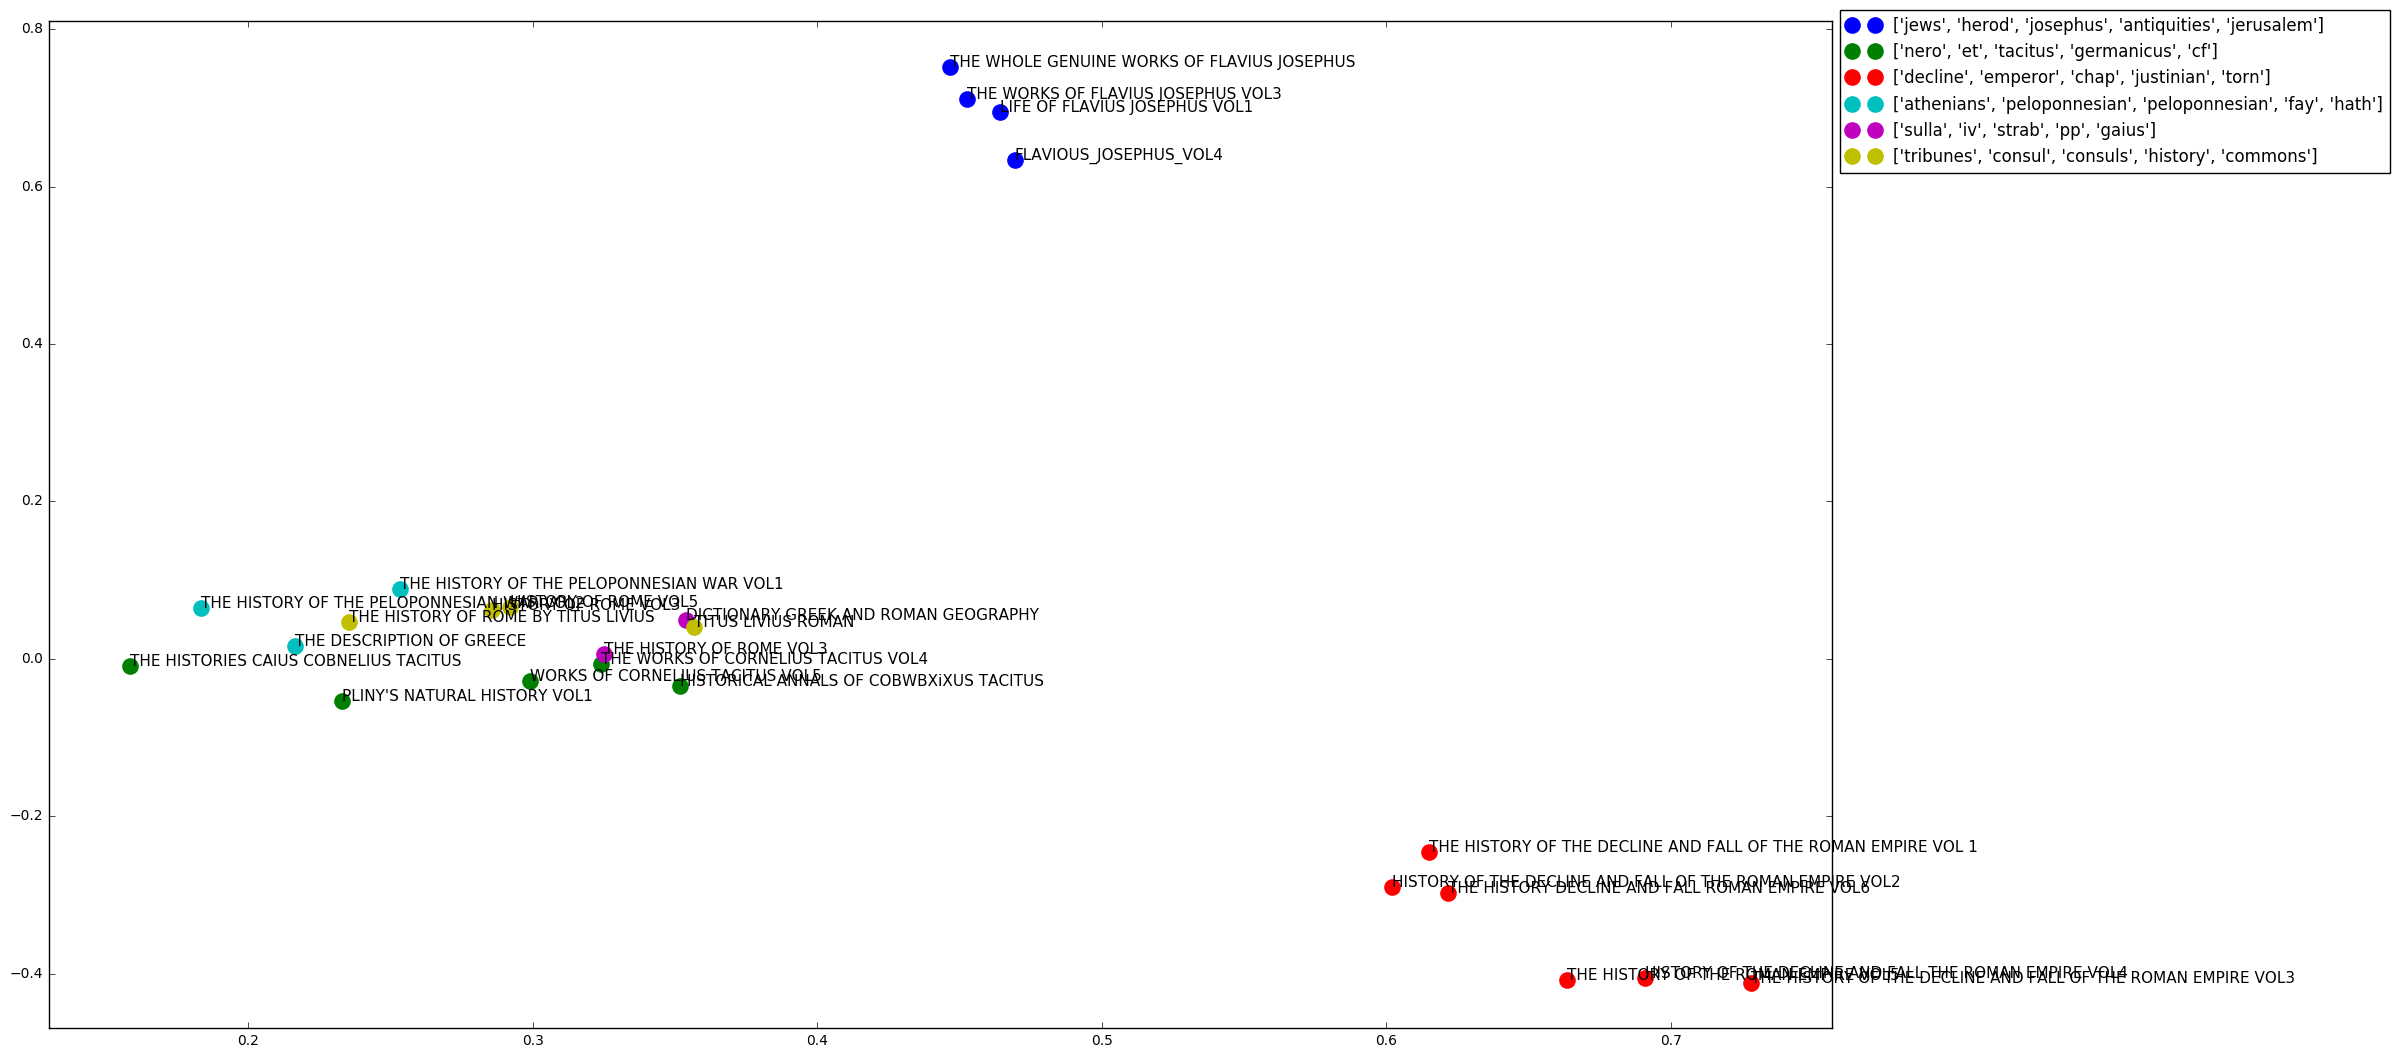

In [10]:
#posLSA
graph_dict = {'x':posLSA[:, 0], 'y':posLSA[:, 1], 'label':clusters, 'title':titles}
df = pd.DataFrame(graph_dict)

groups = df.groupby('label')
ig, ax = plt.subplots(figsize=(23, 13))  # set size
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_names[name][0:5],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params( \
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
    )
    ax.tick_params( \
        axis='y',  # changes apply to the y-axis
        which='both',  # both major and minor ticks are affected
       )

    ax.legend(numpoints=1)  # show legend with only 1 point
    ax.legend(loc='center left', bbox_to_anchor=(1,0.93))


 
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# add label in x,y position with the label as the book title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=11)

df.ix[2]

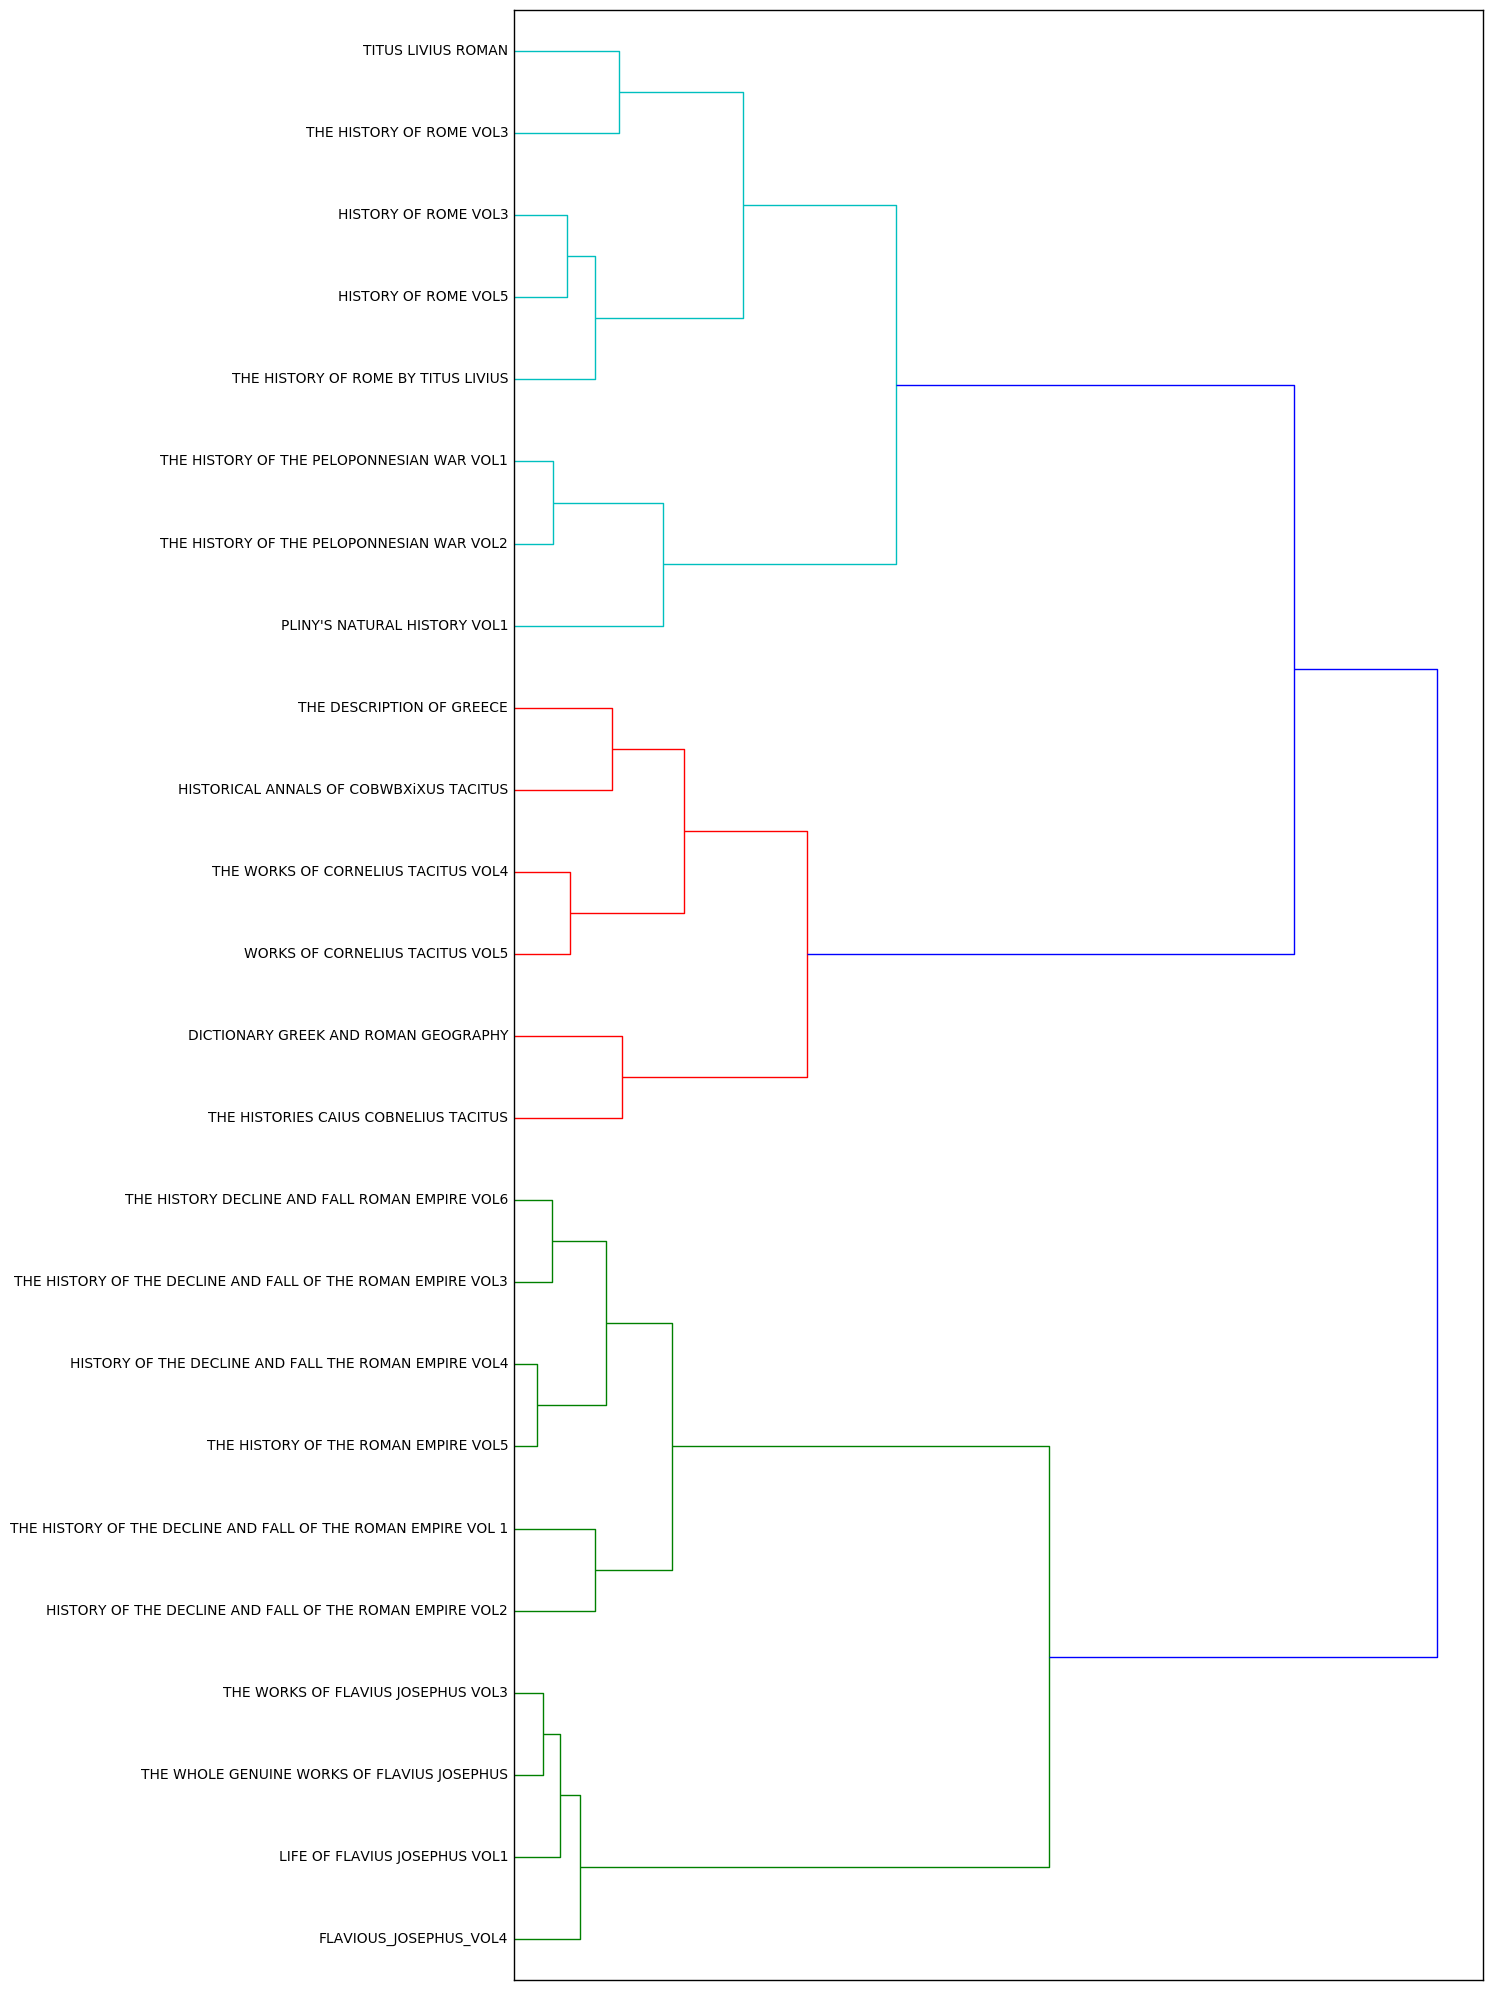

In [11]:

linkage_matrix = ward(pos) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clust

In [12]:
bandwidth = estimate_bandwidth(pos, quantile=0.208)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pos)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 7


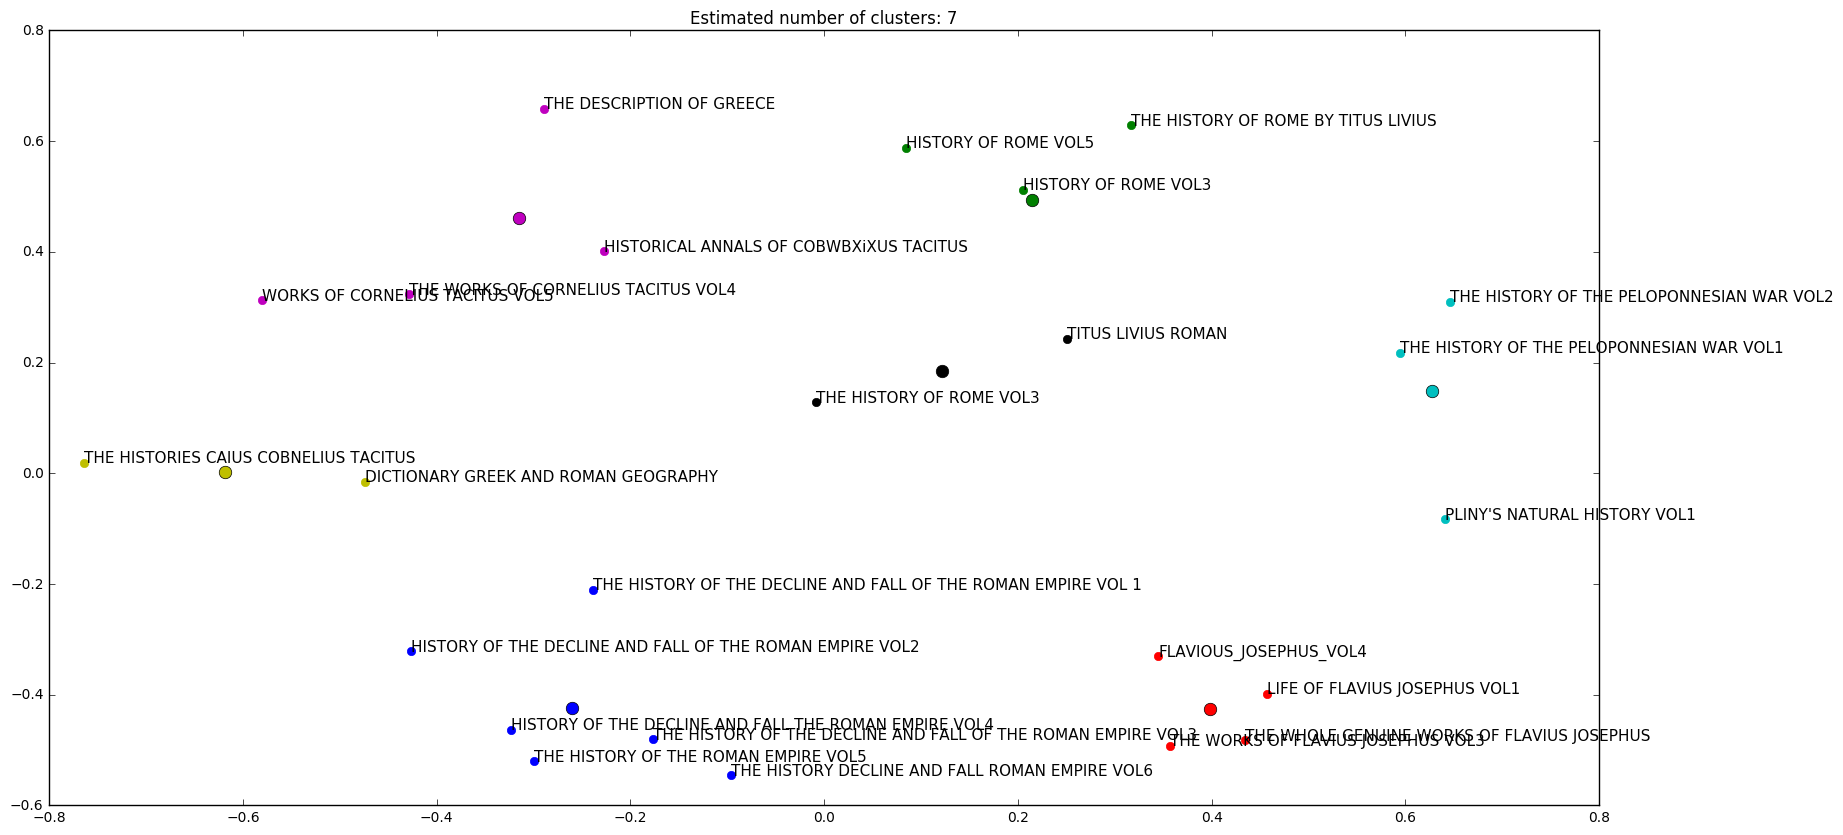

In [13]:
from itertools import cycle

plt.figure(1)
plt.figure(figsize=(20,10))
plt.clf()




colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(pos[my_members, 0], pos[my_members, 1], col + '.', markersize=12)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=9)
plt.title('Estimated number of clusters: %d' % n_clusters_)


for i in range(len(df)):
    plt.text(pos[i, 0], pos[i, 1], df.ix[i]['title'], size=11)

df.ix[2]

plt.show()

In [14]:
#LDA AND NMF

In [15]:
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [16]:

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [17]:
import re
from nltk.corpus import stopwords

nltk.download("stopwords")
english_stopwords = stopwords.words('english')

def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        m = re.match('(\w+)', token)
        if m:
            for c in m.groups():
                filtered_tokens.append(c)
    return filtered_tokens

[nltk_data] Downloading package stopwords to /home/ayoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:


preprocess = [strip_proppers(doc) for doc in book_words_list] #remove proper names
tokenized_text = [tokenize(text) for text in preprocess]#tokenize
texts = [[word for word in text if word not in english_stopwords] for text in tokenized_text]#stopwords


In [19]:

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
lda = models.LdaModel(corpus, 
                      num_topics=6 ,
                            id2word=dictionary, 
                            update_every=6, 
                            chunksize=10000, 
                            passes=100)

In [21]:
lda.show_topics()


[(0,
  '0.006*"strab" + 0.005*"pp" + 0.004*"pliny" + 0.004*"plin" + 0.004*"site" + 0.004*"strabo" + 0.004*"situated" + 0.004*"tbe" + 0.003*"ptolemy" + 0.003*"liv"'),
 (1,
  '0.010*"fhould" + 0.010*"commons" + 0.009*"thefe" + 0.008*"confuls" + 0.008*"thofe" + 0.007*"mould" + 0.007*"conful" + 0.006*"patricians" + 0.006*"fome" + 0.006*"ftate"'),
 (2,
  '0.010*"athenians" + 0.004*"consuls" + 0.003*"peloponnesian" + 0.002*"athenian" + 0.002*"dictator" + 0.002*"hath" + 0.002*"sicily" + 0.002*"scipio" + 0.002*"lucius" + 0.002*"lacedæmonians"'),
 (3,
  '0.009*"sulla" + 0.005*"gracchus" + 0.005*"gaius" + 0.004*"marius" + 0.003*"lucius" + 0.003*"scipio" + 0.003*"aristocracy" + 0.002*"drusus" + 0.002*"communities" + 0.002*"literature"'),
 (4,
  '0.019*"cf" + 0.008*"nero" + 0.006*"tacitus" + 0.005*"galba" + 0.005*"sc" + 0.005*"vitellius" + 0.005*"otho" + 0.004*"non" + 0.004*"ch" + 0.004*"sed"'),
 (5,
  '0.008*"jews" + 0.004*"lib" + 0.003*"herod" + 0.003*"josephus" + 0.003*"decline" + 0.003*"jerusa

In [22]:
nmf = NMF(n_components=6, random_state=1).fit(frequency_term_matrix)

feature_names = term_freq_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-5 - 1:-1]]))
    print()

Topic #0:
justinian chap decline fall emperor lib

Topic #1:
jews herod antiquities jews josephus jerusalem

Topic #2:
consul tribunes consuls history rome samnites

Topic #3:
athenians peloponnesian peloponnesian war lacedaemonians hath

Topic #4:
nero tacitus germanicus otho emperor

Topic #5:
et cf strab iv pp

